In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from __future__ import division
import itertools
import copy
from collections import namedtuple

# Machine Learning for Face Analysis

## LCAV TAM, 27 Feb 2018

### Paolo Prandoni

# Outline

* what I do the other half of the time
* a brief demo
* paper discussion: "One Millisecond Face Alignment with an Ensemble of Regression Trees"

# Aside: why a "reproducible" TAM 

* a shameful confession...
* avoid "points of no return" 
* apologies for the didactic approach

![quividi](quividi.png)


# Live Demo!

# Part 1 - the Paper

 * "One Millisecond Face Alignment with an Ensemble of Regression Trees", by Vahid Kazemi and Josephine Sullivan, KTH, 2014
 
<img src="faces.jpg" alt="landmarks" style="width: 800px;"/> 

## Problem setup:
    
* $I$: $M\times M$ face image, 8-bit, grayscale
* $S$: set of face _shapes_, as $L$ positions of 2D landmarks; $S \in \mathbb{N}^{2L}$ 
* find $F: \mathbb{N}^{M^2} \rightarrow \mathbb{N}^{2L}$ s.t.
$F(I) \approx S$

### 68-point landmark pattern:
<img src="landmarks_68.png" alt="landmarks" style="width: 500px;"/>

## Classic ML problem:

* get a set of N annotated face images $\{I_n, S_n\}$
* train a system on the dataset

### typical shape variability in training set
<img src="face_shape_model.gif" alt="landmarks" style="width: 500px;"/>

## Why Kazemi and Sullivan's approach is nice

* use intelligent "features" rather than raw data
* supplement classic boosting methods with smart ad-hoc observations
* a good mix of ML and intuition

## Ingredient 1: Gradient Boosting

Problem: learn $F(I_n) \approx S_n$

* successive refinement of estimation function: $F^{(i+1)}(I) = F^{(i)}(I) + h^{(i)}(I)$
* ideally: $h^{(i)}(I) = S - F^{(i)}(I)$
* learn a sequence of approximations to the _residuals_ $h^{(i)}(I)$

("gradient" because $\partial h^2/\partial F \propto -h$)

In our case:
* start with an estimate $\hat{S}^{(0)}$ (i.e. average face shape)
* for $i = 0, \ldots, T$:
    * compute residuals $\quad\Delta S^{(i)}_n = S_n - \hat{S}^{(i)} \qquad n = 1, \ldots, N$
    * learn an approximation $\quad r^{(i)}(I_n, \hat{S}^{(i)}_n) \approx \Delta S^{(i)}_n$ 
    * update estimates $\quad\hat{S}^{(i+1)}_n = \hat{S}^{(i)}_n + r^{(i)}(I_n, \hat{S}^{(i)}_n)$
    
    
    
Note: dependence on $\hat{S}^{(i)}_n$ is important

<img src="cascade.jpg" alt="cascade" style="width: 1200px;"/>

## Ingredient 2: Regression Trees and Forests

Learning the residual estimators $r^{(i)}(I, \hat{S})$ 

* use regression trees to approximate the residual
* use boosting (again!) to avoid overfitting and improve generalization
* boosted trees are also called forests

### A brief digression on trees and forests...

### a classification tree

![classification](classification_tree.png)

### regression trees

Piecewise-constant function approximation:
* split function domain recursively 
* use function average over split intervals
* choose the split points at random via a greedy strategy that minimizes the squared error

In [33]:
class RTree:
    def __init__(self, depth):
        self.levels = depth
        self.num_leaves = 2 ** self.levels
        self.num_nodes = self.num_leaves - 1

    def train(self, data):
        N = len(data)
        TRIALS_PER_NODE = 100

        # initialize tree and go through nodes in order
        ix = 0
        self.node = [None] * (self.num_nodes + 1)  # node indexing starts at 1
        self.node[1] = {'A': 0, 'B': N}
        self.leaf = []
        for level in xrange(0, self.levels):
            for k in xrange(0, 2 ** level):
                ix += 1
                # select greedily the best split per node over N trials
                A = self.node[ix]['A']
                B = self.node[ix]['B']
                best = {'err': 1e20, 'S': A}
                for n in xrange(0, TRIALS_PER_NODE):
                    S = A + int(np.floor(np.random.rand() * (B - A + 1)))
                    err = np.square(data[A:S] - data[A:S].mean()).sum() + \
                          np.square(data[S:B] - data[S:B].mean()).sum()
                    if err < best['err']:
                        best = {'err': err, 'S': S}
                # best split found :
                S = best['S']
                self.node[ix]['S'] = S
                if level == self.levels - 1:
                    self.leaf.append(data[A:S].mean())
                    self.leaf.append(data[S:B].mean())
                else:
                    self.node[2*ix] = {'A': A, 'B': S}
                    self.node[2*ix+1] = {'A': S, 'B': B}
                    
    def regress(self, N = 1):
        x = np.zeros(N)
        for n in xrange(0, N):
            ix = 1
            for k in xrange(0, self.levels):
                if n >= self.node[ix]['S']:
                    ix = 2 * ix + 1
                else:
                    ix = 2 * ix
            x[n] = self.leaf[ix - self.num_nodes - 1]
        return x

In [34]:
def test_fit(data, regressor):
    t = eval(regressor)
    t.train(data)
    plt.plot(data)
    plt.plot(t.regress(len(data)), linewidth=5.0)

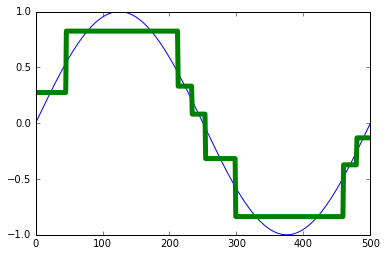

In [35]:
POINTS = 500
x = np.sin(np.arange(0, POINTS) * 2 * np.pi / POINTS)

test_fit(x, 'RTree(3)')

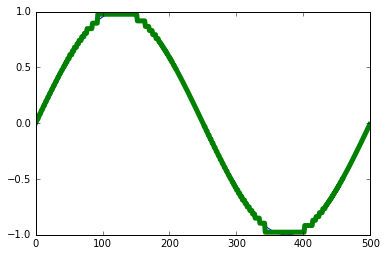

In [36]:
test_fit(x, 'RTree(8)')

### boosting the trees

* trees that are too deep are prone to overfitting (low bias, high variance)
* better to use a forest of shallow trees via boosting
* boosting reduces variance by correcting past classification mistakes

### training a forest

Goal: approximate $f(t)$ with a boosted forest

* $\hat{h}^{(0)}(t) = 0$ (initial estimate)
* for $k = 1, \ldots, K$:
    * compute residual $\quad \rho^{(k)}(t) = f(t) - \hat{h}^{(k-1)}(t)$
    * fit a regression tree $\quad \tau^{(k)}(t) \approx \rho^{(k)}(t)$
    * update $\quad \hat{h}^{(k)}(t) = {\hat{h}}^{(k-1)}(t) + \nu \tau^{(k)}(t)$
    
Forest regressor is $\quad f(t) \approx \nu \sum_k \tau^{(k)}(t)$ 

In [37]:
class RForest:
    def __init__(self, forest_size, tree_depth, nu):
        self.num_trees = forest_size
        self.tree_depth = tree_depth
        self.nu = nu

    def train(self, data):
        self.trees = []
        residual = data.copy()
        for k in xrange(0, self.num_trees):
            rt = RTree(self.tree_depth)
            rt.train(residual)
            self.trees.append(rt)
            residual = residual - self.nu * rt.regress(len(residual))

    def regress(self,  N=1):
        x = np.zeros(N)
        for rt in self.trees:
            x = x + self.nu * rt.regress(N)
        return x            

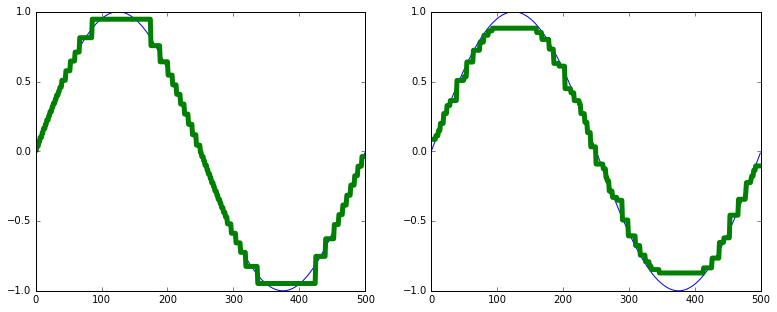

In [38]:
plt.subplots(1, 2, figsize=(13, 5))
plt.subplot(1,2,1)
test_fit(x, 'RTree(6)')
plt.subplot(1,2,2)
test_fit(x, 'RForest(8, 3, 0.3)')

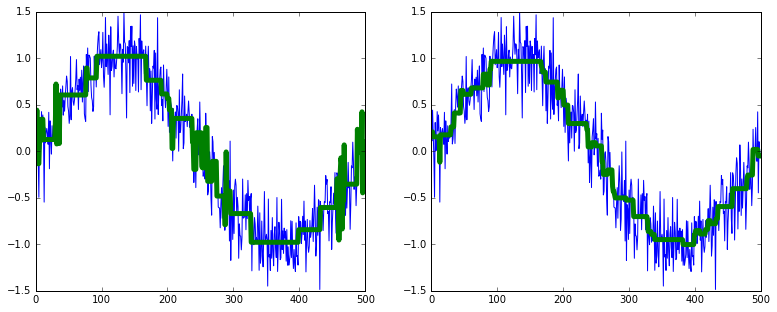

In [39]:
y = x + np.random.randn(POINTS) / 4
plt.subplots(1, 2, figsize=(13, 5))
plt.subplot(1,2,1)
test_fit(y, 'RTree(6)')
plt.subplot(1,2,2)
test_fit(y, 'RForest(8, 3, 0.4)')

### Back to our problem...

Learn a forest regressor to approximate $r^{(i)}(I_n, \hat{S}^{(i)}_n) \approx \Delta S^{(i)}_n$

(it gets confusing because we're approximating a residual with... more residuals!)

* use $I$ and $\hat{S}$ at each stage to produce a pool of $P$ pixel-based binary tests (features)
* tests will be used as split nodes in the trees
* each tree will select different features from the list
* use boosting to combine trees into a forest

### greedy training strategy:

For each node in the tree:
* repeat $C$ times:
    * select a test at random from the pool, split the training set in two subsets
    * compute the average residuals $\bar{\Delta S}_{L}, \bar{\Delta S}_{R}$ for the two sets
    * compute the total MSE resulting from approximating the residuals by their averages
* select the test yielding the lowest MSE

Use the tree boosting algorithm to combine $K$ trees into a forest

## Ingredient 3: "shape-invariant" features

Feature: $\{\mathbf{x, y}, \theta\}$
* $\mathbf{x, y}$ pair of random pixel coordinates
* $\theta$ random threshold

Binary test: $I(\mathbf{x}) - I(\mathbf{y}) > \theta$

Feature pool: set of $P$ random features, with a prior favoring nearby pairs of pixels

#### Shape invariance:

* pixel coordinates are given with respect to reference average shape $\hat{S}^{(0)}$
* at each stage in the cascade:
    * find warping from $\hat{S}^{(0)}$ to $\hat{S}^{(i)}$
    * warp pixel coordinates
* stage-based warping ensures computational efficiency

## Other neat ideas
* augment training set by randomly pairing images and shapes
* using (randomized) actual shapes as initial conditions improves generalization
* using linear regressors implies final estimate is linear combination of training shapes: no deformations

# Part 2 - Toy Example

Try to get all the key concepts from the paper in a self-contained framework:
* simplify the dataset
* have a way to generate automatically-labeled synthetic data
* allow for fast training
* scalable

### simple, 1D equivalent to a "face shape"

* have some initial symmetry
* add perturbation to the symmetry
* add affine transform

Idea: magnitude response of a simple AR system!

<img src="resonator.jpg" alt="resonator" style="width: 500px;"/>

In [11]:
class DataObject:
    POINTS = 512  # number of points in the data object 
    
    @staticmethod
    def rnd():
        # uniform random values between -1 and 1
        return 2 * np.random.rand() - 1
    
    def __init__(self): 
        # data objects are generated as the magnitude response of a 3rd order AR filter
        # From a symmetric pole pattern we apply pole jitter in phase and magnitude
        #  plus a random shift and warp of the whole function 
 
        # Each object defines a three-point shape, corresponding to the peaks of the function
        while True:
            t = 0.35 + 0.1 * self.rnd()
            r = 0.8 + 0.1 * self.rnd()
            center = 0.2 * self.rnd()
            warp = 1 + 0.2 * self.rnd()
            # compute shape
            x = (np.arange(0, self.POINTS) / self.POINTS - 0.5) * 2
            z = np.exp(1.j * (x - center) * warp * np.pi)
            a = 1
            for theta, rho in zip([-t, 0, t], [r, 0.9, r]):
                a *= np.abs(z - rho * np.exp(1.j * theta * np.pi))
            self.data = 1.0 / a
            self.data /= max(self.data)
            # find landmarks
            self.shape = []    
            d = self.data - np.roll(self.data, 1)
            for n in xrange(2, self.POINTS - 2):
                if d[n] * d[n-1] <= 0 and d[n] < 0:
                    self.shape.append(n - 1)
            # only accept shapes with three distinct landmarks
            if len(self.shape) == 3:
                break

    def __repr__(self):
        return self.shape
        
    @classmethod
    def empty_shape(cls):
        return np.array([0, 0, 0])
    
    @classmethod
    def mean_shape(cls):
        # mean shape is for the non-perturbed pole plot
        return (cls.POINTS * np.array([0.33, 0.5, 0.66]))
    
    @classmethod
    def find_warping(cls, estimate):
        # compute warping between reference shape and estimate via least squares fit
        ref = cls.mean_shape()
        if np.array_equal(estimate, ref):
            return [1.0, 0.0]
        c_m = np.mean(estimate)
        r_m = np.mean(ref)
        c_n = estimate - c_m
        r_n = ref - r_m
        m = np.dot(c_n, r_n) / np.dot(r_n, r_n)
        b = c_m - m * r_m
        return [m, b]

    @classmethod
    def get_split(cls):
        # return two random coordinates and a threshold
        p = np.sort(np.random.rand(2) * cls.POINTS)
        return [int(p[0]), int(p[1]), cls.rnd()]
    
    def test_split(self, split, warping = [1.0, 0]):
        # compute the difference between the data object values at the given coordinates
        #  and return 1 if greater than the threshold; use warping if available
        x = [min(max(split[i] * warping[0] + warping[1], 0), self.POINTS-1) for i in [0, 1]] 
        return 1 if self.data[int(x[0])] - self.data[int(x[1])] > split[2] else 0    
        
    def plot(self, estimate = None):
        plt.plot(self.data)
        for t in self.shape:
            plt.plot(t, self.data[t], 'or')
        if estimate is not None:
            for t in estimate:
                plt.plot([t, t], [0, 1], 'g')

### 1D "face"

* function is discretized over $N$ points to give a 1D "image" $I$
* shape $S$ is a size-3 vector indicating the landmark positions (the peaks of the function)


Goal: learn $F(I) \approx S$ for a synthetic training set

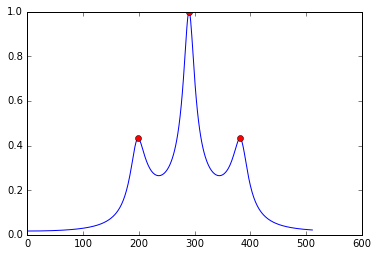

In [77]:
DataObject().plot()

In [78]:
class TrainingSample(DataObject):
    # just an augmented DataObject used for training
    def __init__(self):
        DataObject.__init__(self)
        self.reset()
        
    def reset(self):
        self.estimate = self.mean_shape()
        self.residual = self.shape - self.mean_shape()
        self.stage_estimate = self.mean_shape()
        self.warping = [1.0, 0]
    
    
class DataDB:
    # training and test database
    def __init__(self, num_items):
        self.db = []
        for n in xrange(0, num_items):
            self.db.append(TrainingSample())
            
    def __getitem__(self, ix):
        return self.db[ix]
    
    def __len__(self):
        return len(self.db)
    
    def reset(self):
        for i in self.db:
            i.reset()
        

In [79]:
# create a training database 
db = DataDB(2000)

In [80]:
def test(estimator, N):
    # test a given estimator over a newly generated dataset
    err = 0
    for s in DataDB(N):
        q = estimator.estimate(s)
        err += np.square(s.shape - q).mean()
    err /= N
    print err

### let's try first with  a simple tree

* features are random triples $\{j, k, \theta\}$
* binary split tests are $I[j] - I[k] > \theta$

In [87]:
class RegressionTree:
    def __init__(self, tree_depth):
        self.levels = tree_depth - 1  # do not count leaves
        self.num_leaves = 2 ** self.levels
        self.num_nodes = self.num_leaves - 1
        # nodes hold splits
        self.split = [None, ]  # node indexing starts at 1
        self.leaf = []

    def train(self, db):
        # tree fitting operates only on residuals; residuals are set by the forest training
        TRIALS_PER_SPLIT = 20
        
        # initialize empty tree
        self.split = [None, ]  # node indexing starts at 1
        self.leaf = []
        for t in db:
            t.node = 1
            t.tmp_node = 0

        # go through nodes in order
        node = 0
        for level in xrange(0, self.levels):
            for k in xrange(0, 2 ** level):
                node += 1
                best = {
                    'split': None,
                    'mean': None,
                    'error': 1e20,
                }
                # select greedily the best split per node over N trials
                for n in xrange(0, TRIALS_PER_SPLIT):
                    split = DataObject.get_split()
                    mean = [DataObject.empty_shape(), DataObject.empty_shape()]
                    count = [0, 0] 
                    # compute the average residuals for left and right subtrees 
                    for t in (i for i in db if i.node == node):
                        ix = t.test_split(split, t.warping)
                        # potential next node if we choose this split:
                        t.tmp_node = 2 * node + ix
                        mean[ix] = mean[ix] + t.residual
                        count[ix] += 1
                    for ix in [0, 1]:
                        mean[ix] = mean[ix] / (count[ix] if count[ix] > 0 else 1)
                    # now compute the approximation error for this split
                    error = 0
                    for t in (i for i in db if i.node == node):
                        avg_residual = mean[t.tmp_node & 1]
                        error += np.square(t.residual - avg_residual).mean()
                    if (error < best['error']):
                        best = {'split': split, 'mean': mean, 'error': error}
                        for t in (i for i in db if i.node == node):
                            t.best_node = t.tmp_node
                # best split found :
                self.split.append(best['split'])
                for t in (i for i in db if i.node == node):
                    t.node = t.best_node
                # set leaves' values if last level
                if level == self.levels - 1:
                    self.leaf.append(best['mean'][0])
                    self.leaf.append(best['mean'][1])
        print "*",
    print
    
    def estimate(self, dataobject, prev_est=None):
        # use tree to estimate shape from DataObject (using optional starting point)
        if prev_est is None:
            prev_est = dataobject.mean_shape() 
        warping = dataobject.find_warping(prev_est)
        return prev_est + self.regress(dataobject, warping)
    
    def regress(self, dataobject, warping):
        # use regression tree on dataobject to find shape displacement
        ix = 1
        for k in xrange(0, self.levels):
            if dataobject.test_split(self.split[ix], warping):
                ix = 2 * ix + 1
            else:
                ix = 2 * ix
        return self.leaf[ix - self.num_nodes - 1]

In [88]:
tree = RegressionTree(3)
db.reset()
tree.train(db)

*


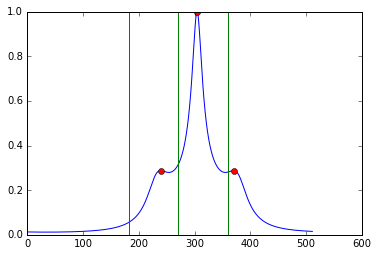

In [89]:
s = DataObject()
est = tree.estimate(s)
s.plot(est)

In [90]:
test(tree, 1000)

821.181902458


* for a single tree not so bad but clearly insufficient
* what if we increase the depth of the tree?

In [91]:
new_tree = RegressionTree(8)
db.reset()
new_tree.train(db)
test(new_tree, 1000)

* 106.700837681


### let's try now with a forest

* use shallow trees (only 4 leaves)
* we can play with the learning factor to avoid overfitting

In [92]:
class RForest:
    def __init__(self, forest_size, tree_depth = 3, nu = 0.5):
        self.num_trees = forest_size
        self.tree_depth = tree_depth
        self.nu = nu

    def train(self, db):
        self.trees = []
        # we use one warping per forest. Init the warping based on current shape
        #  estimate for each object in the db. 
        for t in db:
            t.warping = t.find_warping(t.estimate)
        
        for k in xrange(0, self.num_trees):
            for t in db:
                t.residual = t.shape - t.estimate
            # fit weak regressor to residual
            rt = RegressionTree(self.tree_depth)
            rt.train(db)
            # update estimate (but not warping)
            for t in db:
                t.estimate += self.nu * rt.regress(t, t.warping)
            self.trees.append(rt)

    def estimate(self, dataobject, prev_est=None):
        if prev_est is None:
            prev_est = dataobject.mean_shape() 
        warping = dataobject.find_warping(prev_est)
        r = prev_est
        for rt in self.trees:
            r += self.nu * rt.regress(dataobject, warping)
        return r

In [93]:
forest = RForest(20, 3, 0.5)
db.reset()
forest.train(db)

* * * * * * * * * * * * * * * * * * * *


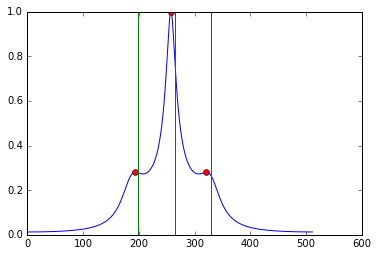

In [94]:
s = DataObject()
est = forest.estimate(s)
s.plot(est)

In [95]:
test(forest, 1000)

67.646730536


### moving on to a cascade

* learn a cascade of forest regressors
* at each stage:
    * for each training sample compute the warping between reference shape and current estimate
    * warp features locations
    * train a forest

In [96]:
class RCascade:
    def __init__(self, stages, forest_size, tree_depth, nu):
        self.num_stages = stages
        self.forest_size = forest_size
        self.tree_depth = tree_depth
        self.nu = nu
        
    def train(self, db):
        self.stages = []
        db.reset()        
        for k in xrange(0, self.num_stages):
            forest = RForest(self.forest_size, self.tree_depth, self.nu)
            forest.train(db)
            self.stages.append(forest)                

    def estimate(self, dataobject):
        r = dataobject.mean_shape()
        for f in self.stages:
            r = f.estimate(dataobject, r)
        return r
    

In [26]:
cascade = RCascade(4, 20, 3, 0.5)
cascade.train(db)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


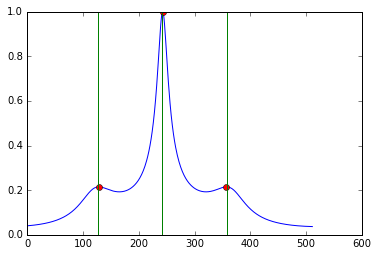

In [76]:
s = DataObject()
est = cascade.estimate(s)
s.plot(est)

In [28]:
test(tree, 1000)
test(forest, 1000)
test(cascade, 1000)

349.029894959
63.96437865
2.19446727735


# questions?

# Thank you.




<br>


Notebook for the presentation available on GitHub: <a href="https://github.com/prandoni/scrapbook">https://github.com/prandoni/scrapbook</a>

Original paper <a href="https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjRu7fdl8TZAhXQ16QKHXqjAQcQFggvMAA&url=https%3A%2F%2Fpdfs.semanticscholar.org%2Fd78b%2F6a5b0dcaa81b1faea5fb0000045a62513567.pdf&usg=AOvVaw0ONvefTf2WUL1c-C1tO8D5">here</a> 